# 500-queen

In this assignment, you need to use efficient backtracking to solve 500-queen problem. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

### CSP and Backtracking 

You do not need to write any code in this section. 

The class below is the base class for all CSP problems. Each specific CSP, such as the N-Queens or map-coloring problem, will be formulated as a class inherited from this CSP class.

Please read the comments inside this class to understand the functionalities of its variables and functions.

In [3]:
class CSP():
    """This class describes finite-domain Constraint Satisfaction Problems.
    A CSP is specified by the following inputs:
        variables   A list of variables; each is atomic (e.g. int or string).
        domains     A dict of {var:[possible_value, ...]} entries.
        neighbors   A dict of {var:[var,...]} that for each variable lists
                    the other variables that participate in constraints.
        constraints A function f(A, a, B, b) that returns true if neighbors
                    A, B satisfy the constraint when they have values A=a, B=b

    In the textbook and in most mathematical definitions, the
    constraints are specified as explicit pairs of allowable values,
    but the formulation here is easier to express and more compact for
    most cases (for example, the n-Queens problem can be represented
    in O(n) space using this notation, instead of O(n^4) for the
    explicit representation). In terms of describing the CSP as a
    problem, that's all there is.

    However, the class also supports data structures and methods that help you
    solve CSPs by calling a search function on the CSP. Methods and slots are
    as follows, where the argument 'a' represents an assignment, which is a
    dict of {var:val} entries:
        assign(var, val, a)     Assign a[var] = val; do other bookkeeping
        unassign(var, a)        Do del a[var], plus other bookkeeping
        conflicts(var, val, a) Return if constaints are satisfied for var=val with assigned variables.
    """

    def __init__(self, variables, domains, neighbors, constraints):
        """Construct a CSP problem. If variables is empty, it becomes domains.keys()."""
        variables = variables or list(domains.keys())
        self.variables = variables
        self.domains = domains
        self.neighbors = neighbors
        self.constraints = constraints

    def assign(self, var, val, assignment):
        """Add {var: val} to assignment; Discard the old value if any."""
        assignment[var] = val

    def unassign(self, var, assignment):
        """Remove {var: val} from assignment.
        DO NOT call this if you are changing a variable to a new value;
        just call assign for that."""
        if var in assignment:
            del assignment[var]

    def conflict(self, var, val, assignment):
        """Return if constaints are satisfied for var=val with assigned variables."""

        # Subclasses may implement this more efficiently
        def conflict_var(var2):
            return var2 in assignment and not self.constraints(var, val, var2, assignment[var2])

        return 0 != np.sum(conflict_var(v) for v in self.neighbors[var])

    # These are for constraint propagation

    def prune(self, var, value, removals):
        """Rule out var=value."""
        self.domains[var].remove(value)
        if removals is not None:
            removals.append((var, value))

    def restore(self, removals):
        """Undo prune and all inferences from it."""
        for B, b in removals:
            self.domains[B].append(b)


This is the class for the N-Queens problem, inherited from the CSP base class. It defines two required parts:

1. Initialization:
    - Variables: n integers representing n queens, with one queen per row.
    - Domains: A list of n integers, meaning each queen can be placed in any column within its row.
    - Neighbors of variables: A list of n-1 integers, indicating that each queen has constraints with all other queens.
2. Constraint Function:

    Defines a function that accepts two queens in two different rows. It returns True if the constraints are satisfied, meaning no conflicts are found.

In [4]:
class NQueensCSP(CSP):
    """
    Make a CSP for the nQueens problem.
    Think of placing queens one per row, from top to bottom.
    That means position (x, y) represents (var, val) in the CSP.
    """

    def __init__(self, n):
        """Initialize data structures for n Queens."""
        domains = {}
        neighbors = {}
        for i in range(n):
            domains[i] = list(range(n))
        for i in range(n): # exclude itself as neighbor 
            all_neighbors = list(range(n))
            neighbors[i] = all_neighbors[:i] + all_neighbors[i+1:]
        CSP.__init__(self, list(range(n)), domains,
                     neighbors, self.constraint)
        
    # put constraints inside the class
    def constraint(self, A, a, B, b):
        # It returns True if the constraints are satisfied, meaning no conflicts are found.
        """Constraint is satisfied (true) if A, B are really the same variable,
        or if they are not in the same row, down diagonal, or up diagonal."""
        # All (i,j) on same diagonal / have same sum i+j, from top left corner 0 to bottom right corner 2n-2
        # All (i,j) on same diagonal \ have same difference i-j, from bottom left corner n-1 to top right corner -(n-1) 
        return A == B or (a != b and A + a != B + b and A - a != B - b)

    def display(self, assignment):
        """Print the queens for n < 30."""
        n = len(assignment)
        board = np.array([2 * int((i + j) % 2) for j in range(n) for i in range(n)]).reshape((n, n))
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111)
        ax.set_title('{} Queens'.format(n))
        plt.imshow(board, cmap='binary', interpolation='nearest')
        # NQueensCSP gives a solution as a dictionary
        if isinstance(assignment, dict):
            for (k, v) in assignment.items():
                plt.annotate('Q', (k,v), color='red', size=200/n)

        fig.tight_layout()
        plt.show()
        
    def verify(self, assignment):
        """Verify if assignment reaches a solution."""
        for var in self.variables:
            if var not in assignment or self.conflict(var, assignment[var], assignment):
                print("Solution is wrong!\n")
                return 
        print("Solution is correct!\n")

The function below defines a naive ordering method for selecting the next unassigned variable to assign a new value.

In [5]:
def first_unassigned_variable(csp, assignment):
    """
    The default variable order.
    Return the first variable in the list of unassigned variables. 
    """
    for var in csp.variables:
        if var not in assignment:
            return var
    return None # if all variables have been assigned. 

The function below defines a dummy filtering method for pruning domains after an assignment. It is a placeholder function that does nothing.

In [6]:
def no_filtering(csp, var, value, assignment, removals):
    """The default filtering.
    """
    return True

The function below defines the backtracking algorithm. It required both ordering and filtering methods. Please read carefully to understand the code.

In [7]:
def backtracking_search(csp, ordering=first_unassigned_variable,
                        filtering=no_filtering):
    """backtracking"""

    def backtrack(assignment):
        # assignment is a dictionary - variable:value or var:val. 
        if len(assignment) == len(csp.variables):
            return assignment
        var = ordering(csp, assignment) # MRV or first_unassigned_variable
        for value in csp.domains[var]: # could use LCV here
            if not csp.conflict(var, value, assignment): # if no conflict 
                csp.assign(var, value, assignment) # assign value to var
                removals = [] # keep values removed from domains of variables during the filtering of forward checking or AC-3. 
                # True if there is no empty domain after filtering. 
                # False causes a backtracking by restoring of removals. 
                if filtering(csp, var, value, assignment, removals): # forward checking or AC-3
                    result = backtrack(assignment) # continue to assign next variable
                    if result is not None:
                        return result
                csp.restore(removals)
        csp.unassign(var, assignment)
        return None

    result = backtrack({})
    return result

### Run backtracking with default setting

- Choose first unassigned variable as ordering.
- Choose first value in its domain as filtering, which does not prune any values from domains of variables after one assignment.

Solution is correct!



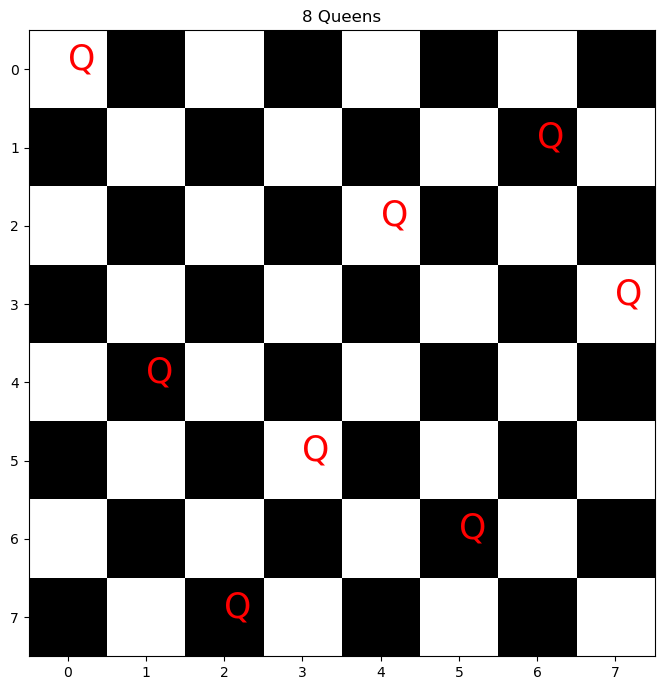

CPU times: user 325 ms, sys: 12.5 ms, total: 338 ms
Wall time: 143 ms


In [8]:
%%time
eight_queens = NQueensCSP(8) # Choose a number less or equal than 15. 
assignment = backtracking_search(eight_queens)
eight_queens.verify(assignment)
eight_queens.display(assignment)

### Run backtracking with forward checking:

Complete the code below to implement forward checking. 

In [9]:
def forward_checking(csp, var, value, assignment, removals):
    """Prune neighbor values inconsistent with var=value.
    
    Pseudocode:
    for every neighbor B of var
        if B is not assigned yet 
            check every value in current domain of B against value of var 
                if constraint is not satisified 
                    prune this value from B
            if domain of B becomes empty 
                return False
     return True
     """
    # Your code goes here:

    for neighbor in csp.neighbors[var]:
        if neighbor not in assignment:
            domain_values = csp.domains[neighbor]
            removed = 0
            for domain_val in domain_values:
                if not csp.constraint(var, value, neighbor, domain_val):
                    csp.prune(neighbor, domain_val, removals)
                    removed += 1
            if removed == len(domain_values):
                return False
    
    return True


For 20-queens, backtracking with forward checking should take less than five seconds to find a solution. 

In [10]:
%%time
eight_queens = NQueensCSP(20)  # Choose a number less or equal than 20. 
assignment = backtracking_search(eight_queens, first_unassigned_variable, forward_checking)
eight_queens.verify(assignment)

# 20 Queens took 4.55 s

Solution is correct!

CPU times: user 4.55 s, sys: 6.92 ms, total: 4.55 s
Wall time: 4.57 s


### Run backtracking with MRV and forward checking:

Complete code below to implement MRV. 

Test your code using MRV and forward checking. 

In [11]:
def mrv(csp, assignment):
    """Minimum-remaining-values heuristic.
    Input: CSP of n-queen.
           Current assignment. 
    Output: An unassigned variable with smallest domain. 
    """
    # Your code goes here: 
    # print(assignment)
    smallest = None
    least_length = float('inf')
    
    for var in csp.variables:
        if var not in assignment:
            if len(csp.domains[var]) < least_length:
                smallest = var
                least_length = len(csp.domains[var])
    
    return smallest

For nqueens, the time that backtracking with MRV and forward checking needs to take to find a solution is:

| N of queens | Time   |   |   |   |
|-------------|--------|---|---|---|
| 20          | 4.9 ms  |   |   |   |
| 100         | 82.4 ms |   |   |   |
| 500         | 4.38 s  |   |   |   |

These runing time is measured on my Mac (MacBook Air (M1, 2020)).

You are expected to take less than 10 seconds to find a solution for 500-queen. 

In [12]:
%%time
eight_queens = NQueensCSP(500)
assignment = backtracking_search(eight_queens, mrv, forward_checking)
eight_queens.verify(assignment)

# 500 Queens took 3.38 s

Solution is correct!

CPU times: user 3.05 s, sys: 272 ms, total: 3.33 s
Wall time: 3.34 s


### Run backtracking with MRV and AC-3:

Complete code below to implement AC-3. 

Test your code using MRV and AC-3. 

In [13]:
def AC3(csp, var, value, assignment, removals):  
    # Prune all inconsistent values in all domains. 
    
    # queue of all paris of queens. 
	queue = [(Xi, Xk) for Xi in csp.variables for Xk in csp.neighbors[Xi]]
    
    
    # prune the domain of the newly assigned variable as the only assigned value var. 
	for v in csp.domains[var][:]: # must use [:] to make a copy. otherwise prune inside the loop changes the domain size. 
		if v != value:
			csp.prune(var, v, removals)

	while queue:
		(Xi, Xj) = queue.pop() # pop out one pair Xi -> Xj for filtering below 
		"""
		update Xi -> Xj to remove values in domain of Xi which conflict with every value in Xj
		if domain of Xi reduces, which means some or all values of Xi pruned
			if domain of Xi is empty, return False since current CSP assignment is inconsistent
			else add all possible affected pairs Xk -> Xi back to queue, but do not add paris that are already in the queue
		"""
		# Your code goes here:
		domain_values_in_Xi = csp.domains[Xi][:]
		domain_values_in_Xj = csp.domains[Xj][:]
		removed = 0
		revised = False
		
		for Xi_value in domain_values_in_Xi:
			is_consistent = False
			for Xj_value in domain_values_in_Xj:
				is_consistent = is_consistent or csp.constraint(Xi, Xi_value, Xj, Xj_value)
		
			if not is_consistent:
				csp.prune(Xi, Xi_value, removals)
				removed += 1
				revised = True
		
		if revised:
			if removed == len(domain_values_in_Xi):
				return False
			else:
				for this_neighbor in csp.neighbors[Xi]:
					if (this_neighbor, Xi) not in queue and this_neighbor != Xj:
							queue.append((this_neighbor, Xi)) 
								
	return True 


For 20-queens, backtracking with MRV and AC-3 should take less than a second to find a solution. 

Please note that AC-3 is slower than forward checking for solving n-queen problem. 

Solution is correct!



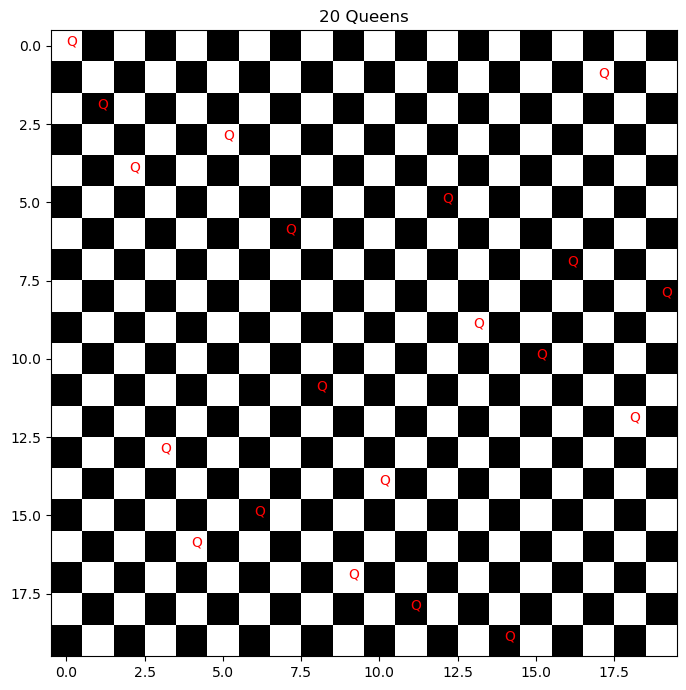

CPU times: user 340 ms, sys: 13 ms, total: 353 ms
Wall time: 155 ms


In [16]:
%%time
eight_queens = NQueensCSP(20)
assignment = backtracking_search(eight_queens, mrv, AC3)
eight_queens.verify(assignment)

# removing display will run this faster
eight_queens.display(assignment)

# 20 Queens took 46.7 ms without display
# 100 Queens took 36.9 s without display
# 500 Queens did not respond for 5 m 13.0 s without display